# Biliotecas

In [ ]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
# %pip install gymnasium[toy-text] imageio[ffmpeg]

zsh:1: no matches found: gymnasium[toy-text]


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Implementação do SARSA

In [12]:

def sarsa(
    env,
    episodes: int,
    alpha: float,
    gamma: float,
    epsilon: float
) -> Tuple[np.ndarray, List[int], List[float], Dict[int, np.ndarray]]:

    # Linha 0 : Inicializa variáveis para armazenar o comprimento dos episódios, retornos e política
    n_states = env.observation_space.n  # Número de estados no ambiente
    n_actions = env.action_space.n      # Número de ações possíveis no ambiente
    q_table = np.zeros((n_states, n_actions))  # Inicializa a Q-table com zeros
    # Pio derivada de Qo: inicialmente uniforme
    politica: Dict[int, np.ndarray] = {
        s: np.ones(n_actions) / n_actions for s in range(n_states)
    }

    episodio_len    : List[int]   = []  # armazena número de passos por episódio
    episodio_return : List[float] = []  # armazena retorno total por episódio

    # (Linha 1) Para cada episódio
    for ep in range(episodes):
        state, _ = env.reset()                            # reinicia o ambiente
        # (Linha 2) Gera A₀ em S₀ seguindo π₀(S₀)
        action = np.random.choice(n_actions, p=politica[state])

        total_return = 0.0
        t = 0
        done = False

        # (Linha 3) Enquanto Sₜ não for estado terminal (no CliffWalking-v0 usamos `done`)
        while not done:
            # (Linha 4) Coleta experiência: Rₜ₊₁, Sₜ₊₁
            next_state, reward, done, truncated, info = env.step(action)
            total_return += reward

            # (Linha 4) Gera Aₜ₊₁ em Sₜ₊₁ seguindo πₜ
            next_action = np.random.choice(n_actions, p=politica[next_state])

            # (Linhas 5–6) Atualiza Q(Sₜ, Aₜ):
            # Q ← Q + α [ Rₜ₊₁ + γ Q(Sₜ₊₁,Aₜ₊₁) − Q(Sₜ,Aₜ) ]
            td_target = reward + gamma * q_table[next_state, next_action]
            td_error  = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            # (Linhas 7–9) Atualiza política ε-greedy em Sₜ:
            best_action = np.argmax(q_table[state])
            for a in range(n_actions):
                if a == best_action:
                    # (Linha 8) ação gulosa com prob. 1−ε + ε/|A|
                    politica[state][a] = 1 - epsilon + epsilon / n_actions
                else:
                    # (Linha 9) demais ações com prob. ε/|A|
                    politica[state][a] = epsilon / n_actions

            # (Linha 10) Avança para o próximo passo: Sₜ ← Sₜ₊₁, Aₜ ← Aₜ₊₁
            state, action = next_state, next_action
            t += 1

        # registra métricas do episódio
        episodio_len.append(t)
        episodio_return.append(total_return)

    return q_table, episodio_len, episodio_return, politica

# Visualização

In [39]:
def plotar_metricas(episodio_len: list[int], episodio_return: list[float], janela: int = 100) -> None:
    """
    Plota as métricas de comprimento e retorno dos episódios.
    :param episodio_len: Lista de comprimentos dos episódios.
    :param episodio_return: Lista de retornos dos episódios.
    :param janela: Tamanho da janela para suavização dos dados.
    """
    # Plot duração do episódio por episódio e a recompensa total por episodio.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodio_len, label='Comprimento do Episódio', color='blue')
    plt.xlabel('Episódio')
    plt.ylabel('Comprimento')
    plt.title('Comprimento do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodio_return, label='Retorno do Episódio', color='green')
    plt.xlabel('Episódio')
    plt.ylabel('Retorno')
    plt.title('Retorno do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [13]:
def gerar_gif_epsilon_greedy_politica(
    politica: Dict[int, np.ndarray],
    env,
    path_gif: str,
    n_episodios: int = 5
) -> str:
    frames = []
    n_actions = len(next(iter(politica.values())))

    for ep in range(n_episodios):
        state, _ = env.reset()
        for _ in range(100):
            action = np.random.choice(n_actions, p=politica[state])
            state, reward, terminated, truncated, _ = env.step(action)
            frames.append(env.render())
            if terminated or truncated:
                break

    env.close()
    imageio.mimsave(path_gif, frames, format="GIF", fps=2)
    return path_gif

# Simulação

In [35]:
# Configura o ambiente
map_name = '8x8'
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # torna o ambiente determinístico ou estocástico
env = gym.make("CliffWalking-v0")

In [36]:
# Hiper-parâmetros principais
EPISODIOS = 1000  # @param {type:"integer"}
ALPHA     = 0.2      # @param {type:"number"}  # comprimento máximo da sequência (+1 p/ token deslocado)
GAMMA     = 0.99     # @param {type:"number"}
EPSILON   = 0.1     # @param {type:"number"}

# Sarsa
q_table, ep_len, ep_ret, politica_eps = sarsa(
    env,
    episodes=EPISODIOS,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

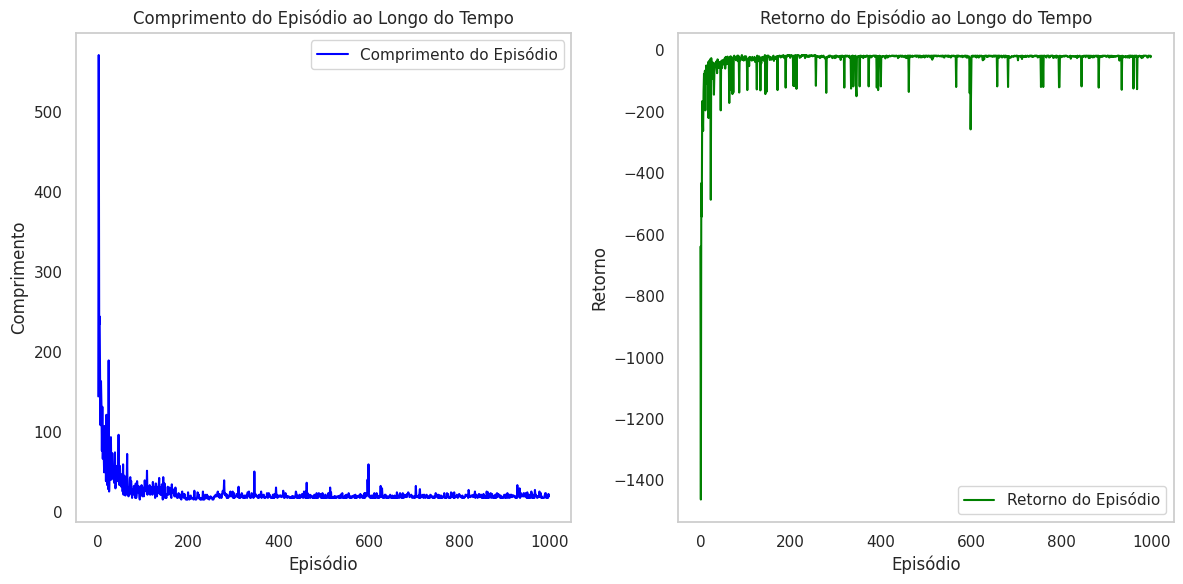

In [40]:
plotar_metricas(ep_len, ep_ret)

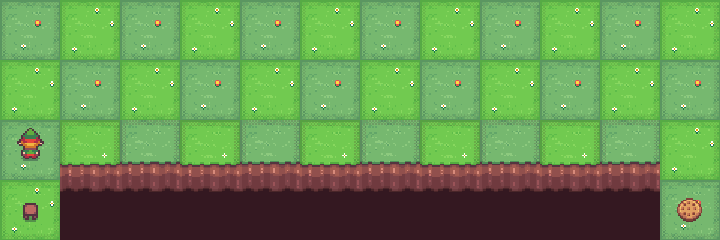

In [38]:
# Recria ambiente para renderizar
env_vis = gym.make("CliffWalking-v0", render_mode="rgb_array")

# Gera o GIF
gif_path = "politica_epsilon_gulosa.gif"
gerar_gif_epsilon_greedy_politica(politica_eps, env_vis, gif_path, n_episodios=5)


# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa:

1. Implemente o algoritmo Sarsa
2. Considere os 4 hiperparametros (EPISODIOS, ALPHA, GAMMA, EPSILON). Varie um dos hiperparametros (ex.: EPISODIOS) e fixe os demais (ex.: ALPHA, GAMMA, EPSILON). Repita o procedimento para cada um dos hiperparametros. Reporte suas observações.
3. Plote a duração do episódio por episódio e também a recompensa total por episodio.

### Impacto do número de episódios

In [41]:
# Teste variando o número de episódios
episodios_variar = [100, 500, 1000, 2000, 5000]
resultados_episodios = {}

# Hiperparâmetros fixos
ALPHA_FIXO = 0.2
GAMMA_FIXO = 0.99
EPSILON_FIXO = 0.1

print("Testando impacto do número de episódios...")
for ep in episodios_variar:
    print(f"Executando com {ep} episódios...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=ep,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_episodios[ep] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de episódios concluído!")

Testando impacto do número de episódios...
Executando com 100 episódios...
Executando com 500 episódios...
Executando com 1000 episódios...
Executando com 1000 episódios...
Executando com 2000 episódios...
Executando com 2000 episódios...
Executando com 5000 episódios...
Executando com 5000 episódios...
Teste de episódios concluído!
Teste de episódios concluído!


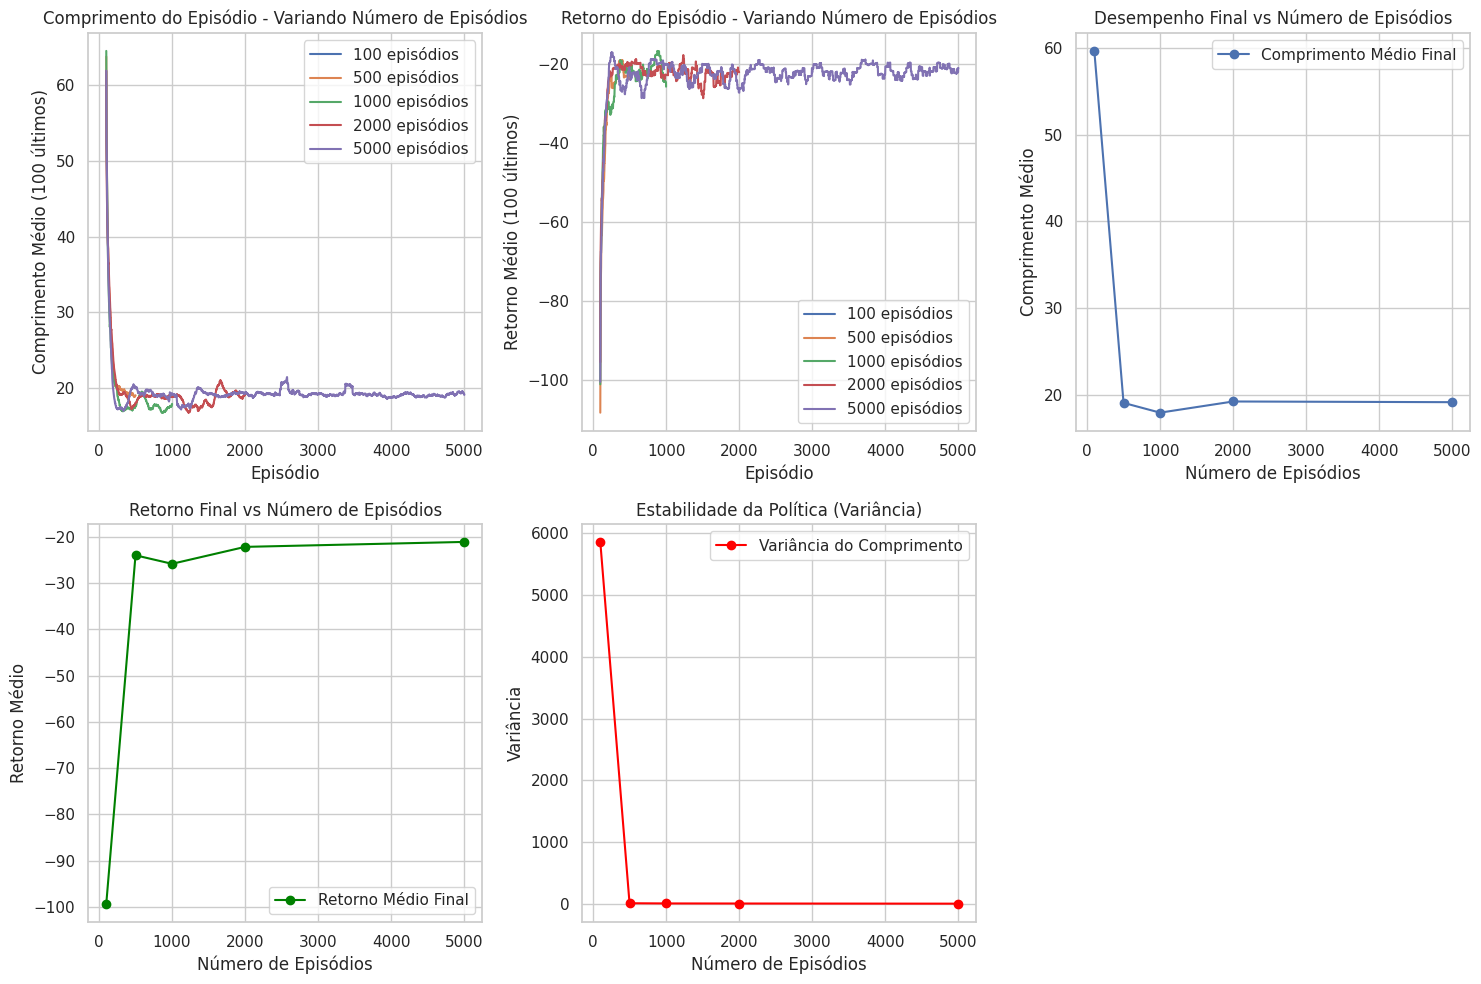


=== ANÁLISE DO IMPACTO DO NÚMERO DE EPISÓDIOS ===

100 episódios:
  Comprimento médio final: 59.67
  Retorno médio final: -99.27
  Variância do comprimento: 5860.38

500 episódios:
  Comprimento médio final: 19.05
  Retorno médio final: -24.00
  Variância do comprimento: 10.37

1000 episódios:
  Comprimento médio final: 17.92
  Retorno médio final: -25.84
  Variância do comprimento: 7.29

2000 episódios:
  Comprimento médio final: 19.21
  Retorno médio final: -22.18
  Variância do comprimento: 6.11

5000 episódios:
  Comprimento médio final: 19.13
  Retorno médio final: -21.11
  Variância do comprimento: 3.71


In [42]:
# Plotar resultados para variação de episódios
plt.figure(figsize=(15, 10))

# Plot 1: Comprimento médio dos últimos 100 episódios
plt.subplot(2, 3, 1)
for ep in episodios_variar:
    ep_len = resultados_episodios[ep]['ep_len']
    # Média móvel dos últimos 100 episódios
    if len(ep_len) >= 100:
        media_movel = pd.Series(ep_len).rolling(window=100).mean()
        plt.plot(media_movel, label=f'{ep} episódios')
plt.xlabel('Episódio')
plt.ylabel('Comprimento Médio (100 últimos)')
plt.title('Comprimento do Episódio - Variando Número de Episódios')
plt.legend()
plt.grid(True)

# Plot 2: Retorno médio dos últimos 100 episódios
plt.subplot(2, 3, 2)
for ep in episodios_variar:
    ep_ret = resultados_episodios[ep]['ep_ret']
    if len(ep_ret) >= 100:
        media_movel = pd.Series(ep_ret).rolling(window=100).mean()
        plt.plot(media_movel, label=f'{ep} episódios')
plt.xlabel('Episódio')
plt.ylabel('Retorno Médio (100 últimos)')
plt.title('Retorno do Episódio - Variando Número de Episódios')
plt.legend()
plt.grid(True)

# Plot 3: Desempenho final (últimos 100 episódios)
plt.subplot(2, 3, 3)
comprimentos_finais = []
retornos_finais = []
for ep in episodios_variar:
    ep_len = resultados_episodios[ep]['ep_len']
    ep_ret = resultados_episodios[ep]['ep_ret']
    comprimentos_finais.append(np.mean(ep_len[-100:]) if len(ep_len) >= 100 else np.mean(ep_len))
    retornos_finais.append(np.mean(ep_ret[-100:]) if len(ep_ret) >= 100 else np.mean(ep_ret))

plt.plot(episodios_variar, comprimentos_finais, 'o-', label='Comprimento Médio Final')
plt.xlabel('Número de Episódios')
plt.ylabel('Comprimento Médio')
plt.title('Desempenho Final vs Número de Episódios')
plt.grid(True)
plt.legend()

# Plot 4: Retorno final
plt.subplot(2, 3, 4)
plt.plot(episodios_variar, retornos_finais, 'o-', color='green', label='Retorno Médio Final')
plt.xlabel('Número de Episódios')
plt.ylabel('Retorno Médio')
plt.title('Retorno Final vs Número de Episódios')
plt.grid(True)
plt.legend()

# Plot 5: Convergência (últimos 100 episódios - variância)
plt.subplot(2, 3, 5)
variancia_comprimento = []
for ep in episodios_variar:
    ep_len = resultados_episodios[ep]['ep_len']
    variancia_comprimento.append(np.var(ep_len[-100:]) if len(ep_len) >= 100 else np.var(ep_len))

plt.plot(episodios_variar, variancia_comprimento, 'o-', color='red', label='Variância do Comprimento')
plt.xlabel('Número de Episódios')
plt.ylabel('Variância')
plt.title('Estabilidade da Política (Variância)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Análise textual
print("\n=== ANÁLISE DO IMPACTO DO NÚMERO DE EPISÓDIOS ===")
for i, ep in enumerate(episodios_variar):
    print(f"\n{ep} episódios:")
    print(f"  Comprimento médio final: {comprimentos_finais[i]:.2f}")
    print(f"  Retorno médio final: {retornos_finais[i]:.2f}")
    print(f"  Variância do comprimento: {variancia_comprimento[i]:.2f}")

### Impacto do alpha


In [43]:
# Teste variando o alpha (taxa de aprendizado)
alphas_variar = [0.01, 0.1, 0.2, 0.5, 0.9]
resultados_alpha = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
GAMMA_FIXO = 0.99
EPSILON_FIXO = 0.1

print("Testando impacto do alpha (taxa de aprendizado)...")
for alpha in alphas_variar:
    print(f"Executando com alpha = {alpha}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=alpha,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_alpha[alpha] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de alpha concluído!")

Testando impacto do alpha (taxa de aprendizado)...
Executando com alpha = 0.01...
Executando com alpha = 0.1...
Executando com alpha = 0.1...
Executando com alpha = 0.2...
Executando com alpha = 0.2...
Executando com alpha = 0.5...
Executando com alpha = 0.5...
Executando com alpha = 0.9...
Executando com alpha = 0.9...
Teste de alpha concluído!
Teste de alpha concluído!


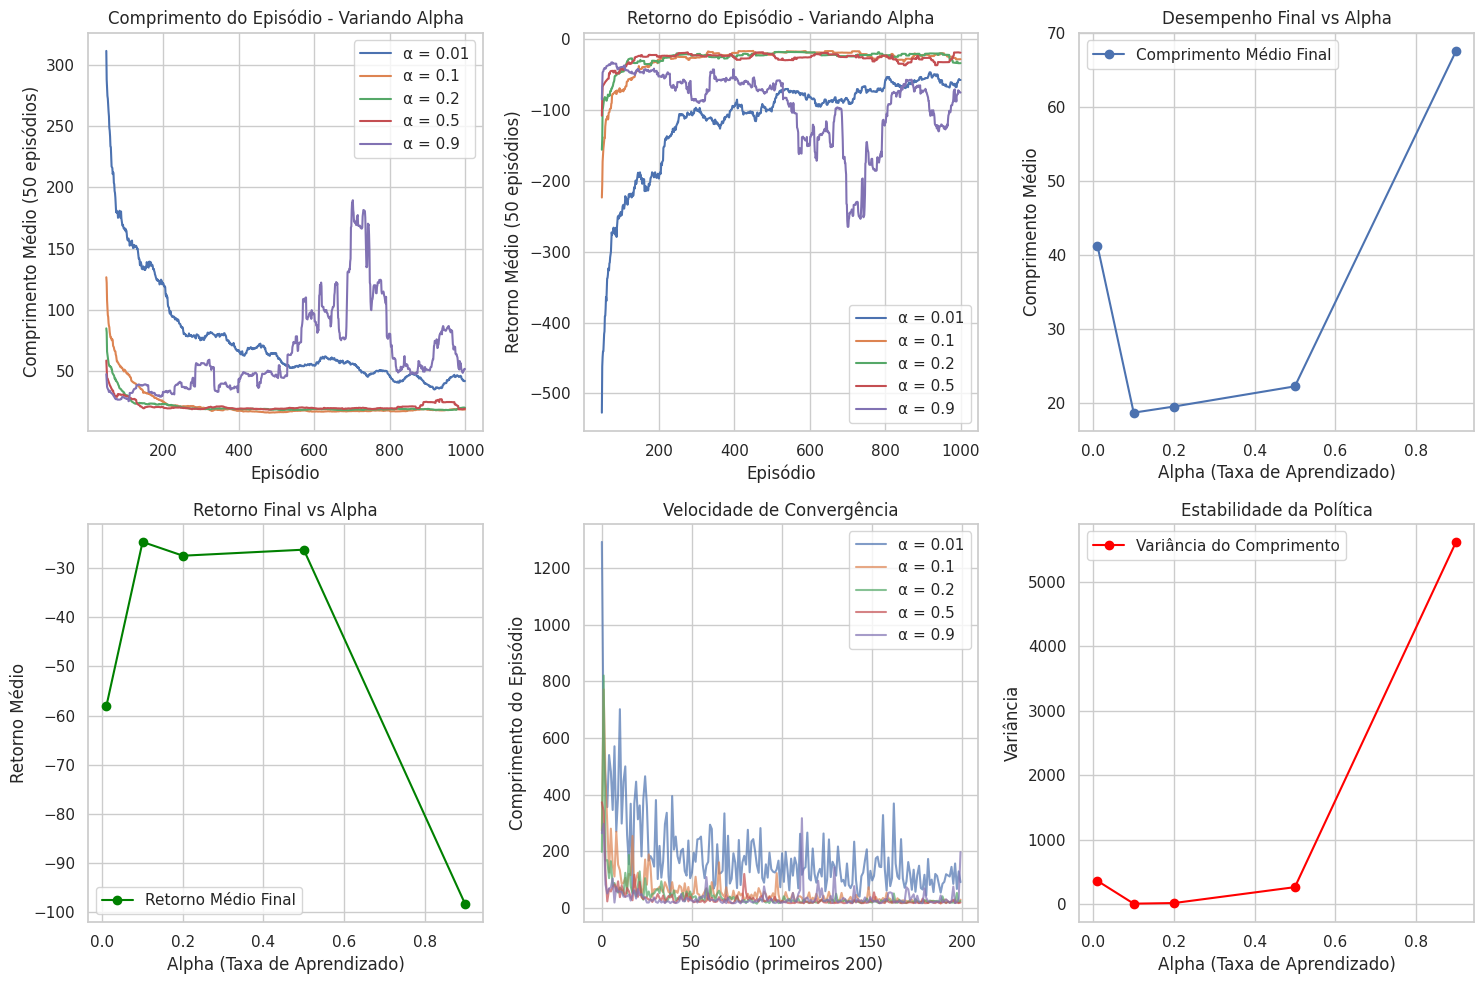


=== ANÁLISE DO IMPACTO DO ALPHA ===

Alpha = 0.01:
  Comprimento médio final: 41.31
  Retorno médio final: -58.14
  Variância do comprimento: 359.87

Alpha = 0.1:
  Comprimento médio final: 18.69
  Retorno médio final: -24.63
  Variância do comprimento: 5.87

Alpha = 0.2:
  Comprimento médio final: 19.52
  Retorno médio final: -27.44
  Variância do comprimento: 15.43

Alpha = 0.5:
  Comprimento médio final: 22.25
  Retorno médio final: -26.21
  Variância do comprimento: 262.19

Alpha = 0.9:
  Comprimento médio final: 67.64
  Retorno médio final: -98.33
  Variância do comprimento: 5618.27


In [44]:
# Plotar resultados para variação de alpha
plt.figure(figsize=(15, 10))

# Plot 1: Comprimento ao longo dos episódios
plt.subplot(2, 3, 1)
for alpha in alphas_variar:
    ep_len = resultados_alpha[alpha]['ep_len']
    # Média móvel
    media_movel = pd.Series(ep_len).rolling(window=50).mean()
    plt.plot(media_movel, label=f'α = {alpha}')
plt.xlabel('Episódio')
plt.ylabel('Comprimento Médio (50 episódios)')
plt.title('Comprimento do Episódio - Variando Alpha')
plt.legend()
plt.grid(True)

# Plot 2: Retorno ao longo dos episódios
plt.subplot(2, 3, 2)
for alpha in alphas_variar:
    ep_ret = resultados_alpha[alpha]['ep_ret']
    media_movel = pd.Series(ep_ret).rolling(window=50).mean()
    plt.plot(media_movel, label=f'α = {alpha}')
plt.xlabel('Episódio')
plt.ylabel('Retorno Médio (50 episódios)')
plt.title('Retorno do Episódio - Variando Alpha')
plt.legend()
plt.grid(True)

# Plot 3: Desempenho final
plt.subplot(2, 3, 3)
comprimentos_finais_alpha = []
retornos_finais_alpha = []
for alpha in alphas_variar:
    ep_len = resultados_alpha[alpha]['ep_len']
    ep_ret = resultados_alpha[alpha]['ep_ret']
    comprimentos_finais_alpha.append(np.mean(ep_len[-100:]))
    retornos_finais_alpha.append(np.mean(ep_ret[-100:]))

plt.plot(alphas_variar, comprimentos_finais_alpha, 'o-', label='Comprimento Médio Final')
plt.xlabel('Alpha (Taxa de Aprendizado)')
plt.ylabel('Comprimento Médio')
plt.title('Desempenho Final vs Alpha')
plt.grid(True)
plt.legend()

# Plot 4: Retorno final
plt.subplot(2, 3, 4)
plt.plot(alphas_variar, retornos_finais_alpha, 'o-', color='green', label='Retorno Médio Final')
plt.xlabel('Alpha (Taxa de Aprendizado)')
plt.ylabel('Retorno Médio')
plt.title('Retorno Final vs Alpha')
plt.grid(True)
plt.legend()

# Plot 5: Velocidade de convergência (primeiros 200 episódios)
plt.subplot(2, 3, 5)
for alpha in alphas_variar:
    ep_len = resultados_alpha[alpha]['ep_len'][:200]
    plt.plot(ep_len, label=f'α = {alpha}', alpha=0.7)
plt.xlabel('Episódio (primeiros 200)')
plt.ylabel('Comprimento do Episódio')
plt.title('Velocidade de Convergência')
plt.legend()
plt.grid(True)

# Plot 6: Estabilidade (variância dos últimos 100 episódios)
plt.subplot(2, 3, 6)
variancia_alpha = []
for alpha in alphas_variar:
    ep_len = resultados_alpha[alpha]['ep_len']
    variancia_alpha.append(np.var(ep_len[-100:]))

plt.plot(alphas_variar, variancia_alpha, 'o-', color='red', label='Variância do Comprimento')
plt.xlabel('Alpha (Taxa de Aprendizado)')
plt.ylabel('Variância')
plt.title('Estabilidade da Política')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Análise textual
print("\n=== ANÁLISE DO IMPACTO DO ALPHA ===")
for i, alpha in enumerate(alphas_variar):
    print(f"\nAlpha = {alpha}:")
    print(f"  Comprimento médio final: {comprimentos_finais_alpha[i]:.2f}")
    print(f"  Retorno médio final: {retornos_finais_alpha[i]:.2f}")
    print(f"  Variância do comprimento: {variancia_alpha[i]:.2f}")

### Impacto do gamma

In [45]:
# Teste variando o gamma (fator de desconto)
gammas_variar = [0.5, 0.8, 0.9, 0.95, 0.99]
resultados_gamma = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
ALPHA_FIXO = 0.2
EPSILON_FIXO = 0.1

print("Testando impacto do gamma (fator de desconto)...")
for gamma in gammas_variar:
    print(f"Executando com gamma = {gamma}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=gamma,
        epsilon=EPSILON_FIXO
    )
    
    resultados_gamma[gamma] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de gamma concluído!")

Testando impacto do gamma (fator de desconto)...
Executando com gamma = 0.5...
Executando com gamma = 0.8...
Executando com gamma = 0.8...
Executando com gamma = 0.9...
Executando com gamma = 0.9...
Executando com gamma = 0.95...
Executando com gamma = 0.95...
Executando com gamma = 0.99...
Executando com gamma = 0.99...
Teste de gamma concluído!
Teste de gamma concluído!


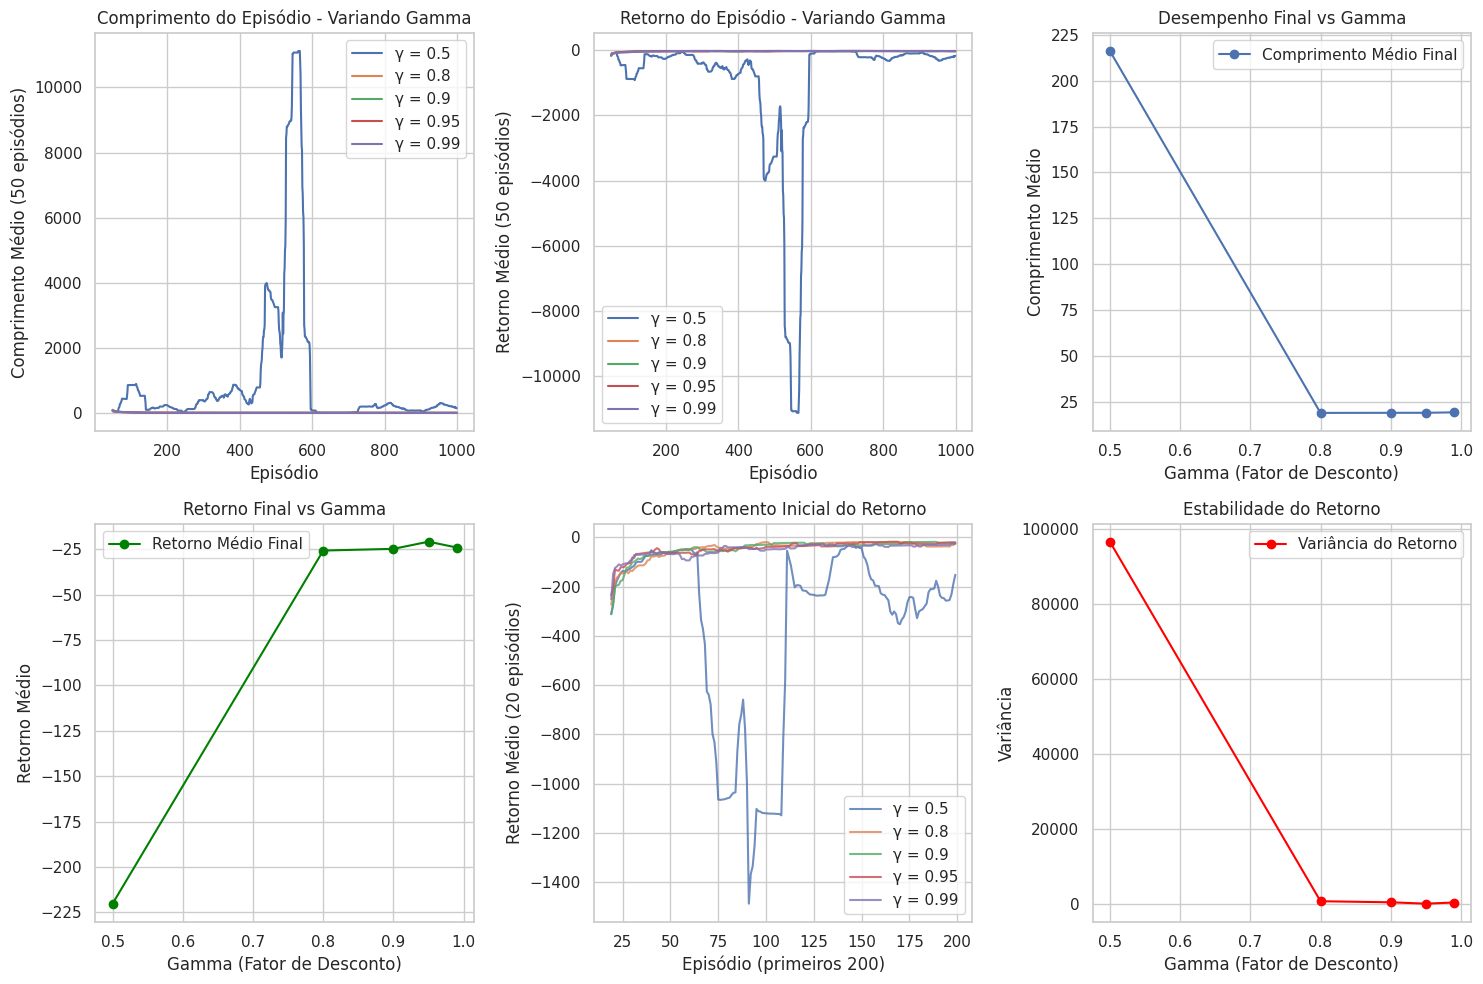


=== ANÁLISE DO IMPACTO DO GAMMA ===

Gamma = 0.5:
  Comprimento médio final: 216.29
  Retorno médio final: -220.25
  Variância do retorno: 96673.55

Gamma = 0.8:
  Comprimento médio final: 18.83
  Retorno médio final: -25.76
  Variância do retorno: 843.88

Gamma = 0.9:
  Comprimento médio final: 18.88
  Retorno médio final: -24.82
  Variância do retorno: 560.01

Gamma = 0.95:
  Comprimento médio final: 18.89
  Retorno médio final: -20.87
  Variância do retorno: 197.95

Gamma = 0.99:
  Comprimento médio final: 19.13
  Retorno médio final: -24.08
  Variância do retorno: 501.55


In [46]:
# Plotar resultados para variação de gamma
plt.figure(figsize=(15, 10))

# Plot 1: Comprimento ao longo dos episódios
plt.subplot(2, 3, 1)
for gamma in gammas_variar:
    ep_len = resultados_gamma[gamma]['ep_len']
    media_movel = pd.Series(ep_len).rolling(window=50).mean()
    plt.plot(media_movel, label=f'γ = {gamma}')
plt.xlabel('Episódio')
plt.ylabel('Comprimento Médio (50 episódios)')
plt.title('Comprimento do Episódio - Variando Gamma')
plt.legend()
plt.grid(True)

# Plot 2: Retorno ao longo dos episódios
plt.subplot(2, 3, 2)
for gamma in gammas_variar:
    ep_ret = resultados_gamma[gamma]['ep_ret']
    media_movel = pd.Series(ep_ret).rolling(window=50).mean()
    plt.plot(media_movel, label=f'γ = {gamma}')
plt.xlabel('Episódio')
plt.ylabel('Retorno Médio (50 episódios)')
plt.title('Retorno do Episódio - Variando Gamma')
plt.legend()
plt.grid(True)

# Plot 3: Desempenho final
plt.subplot(2, 3, 3)
comprimentos_finais_gamma = []
retornos_finais_gamma = []
for gamma in gammas_variar:
    ep_len = resultados_gamma[gamma]['ep_len']
    ep_ret = resultados_gamma[gamma]['ep_ret']
    comprimentos_finais_gamma.append(np.mean(ep_len[-100:]))
    retornos_finais_gamma.append(np.mean(ep_ret[-100:]))

plt.plot(gammas_variar, comprimentos_finais_gamma, 'o-', label='Comprimento Médio Final')
plt.xlabel('Gamma (Fator de Desconto)')
plt.ylabel('Comprimento Médio')
plt.title('Desempenho Final vs Gamma')
plt.grid(True)
plt.legend()

# Plot 4: Retorno final
plt.subplot(2, 3, 4)
plt.plot(gammas_variar, retornos_finais_gamma, 'o-', color='green', label='Retorno Médio Final')
plt.xlabel('Gamma (Fator de Desconto)')
plt.ylabel('Retorno Médio')
plt.title('Retorno Final vs Gamma')
plt.grid(True)
plt.legend()

# Plot 5: Comportamento inicial (primeiros 200 episódios)
plt.subplot(2, 3, 5)
for gamma in gammas_variar:
    ep_ret = resultados_gamma[gamma]['ep_ret'][:200]
    media_movel = pd.Series(ep_ret).rolling(window=20).mean()
    plt.plot(media_movel, label=f'γ = {gamma}', alpha=0.8)
plt.xlabel('Episódio (primeiros 200)')
plt.ylabel('Retorno Médio (20 episódios)')
plt.title('Comportamento Inicial do Retorno')
plt.legend()
plt.grid(True)

# Plot 6: Estabilidade
plt.subplot(2, 3, 6)
variancia_gamma = []
for gamma in gammas_variar:
    ep_ret = resultados_gamma[gamma]['ep_ret']
    variancia_gamma.append(np.var(ep_ret[-100:]))

plt.plot(gammas_variar, variancia_gamma, 'o-', color='red', label='Variância do Retorno')
plt.xlabel('Gamma (Fator de Desconto)')
plt.ylabel('Variância')
plt.title('Estabilidade do Retorno')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Análise textual
print("\n=== ANÁLISE DO IMPACTO DO GAMMA ===")
for i, gamma in enumerate(gammas_variar):
    print(f"\nGamma = {gamma}:")
    print(f"  Comprimento médio final: {comprimentos_finais_gamma[i]:.2f}")
    print(f"  Retorno médio final: {retornos_finais_gamma[i]:.2f}")
    print(f"  Variância do retorno: {variancia_gamma[i]:.2f}")

### Impacto do epsilon

In [47]:
# Teste variando o epsilon (taxa de exploração)
epsilons_variar = [0.01, 0.05, 0.1, 0.3, 0.5]
resultados_epsilon = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
ALPHA_FIXO = 0.2
GAMMA_FIXO = 0.99

print("Testando impacto do epsilon (taxa de exploração)...")
for epsilon in epsilons_variar:
    print(f"Executando com epsilon = {epsilon}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=epsilon
    )
    
    resultados_epsilon[epsilon] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de epsilon concluído!")

Testando impacto do epsilon (taxa de exploração)...
Executando com epsilon = 0.01...
Executando com epsilon = 0.05...
Executando com epsilon = 0.05...
Executando com epsilon = 0.1...
Executando com epsilon = 0.1...
Executando com epsilon = 0.3...
Executando com epsilon = 0.3...
Executando com epsilon = 0.5...
Executando com epsilon = 0.5...
Teste de epsilon concluído!
Teste de epsilon concluído!


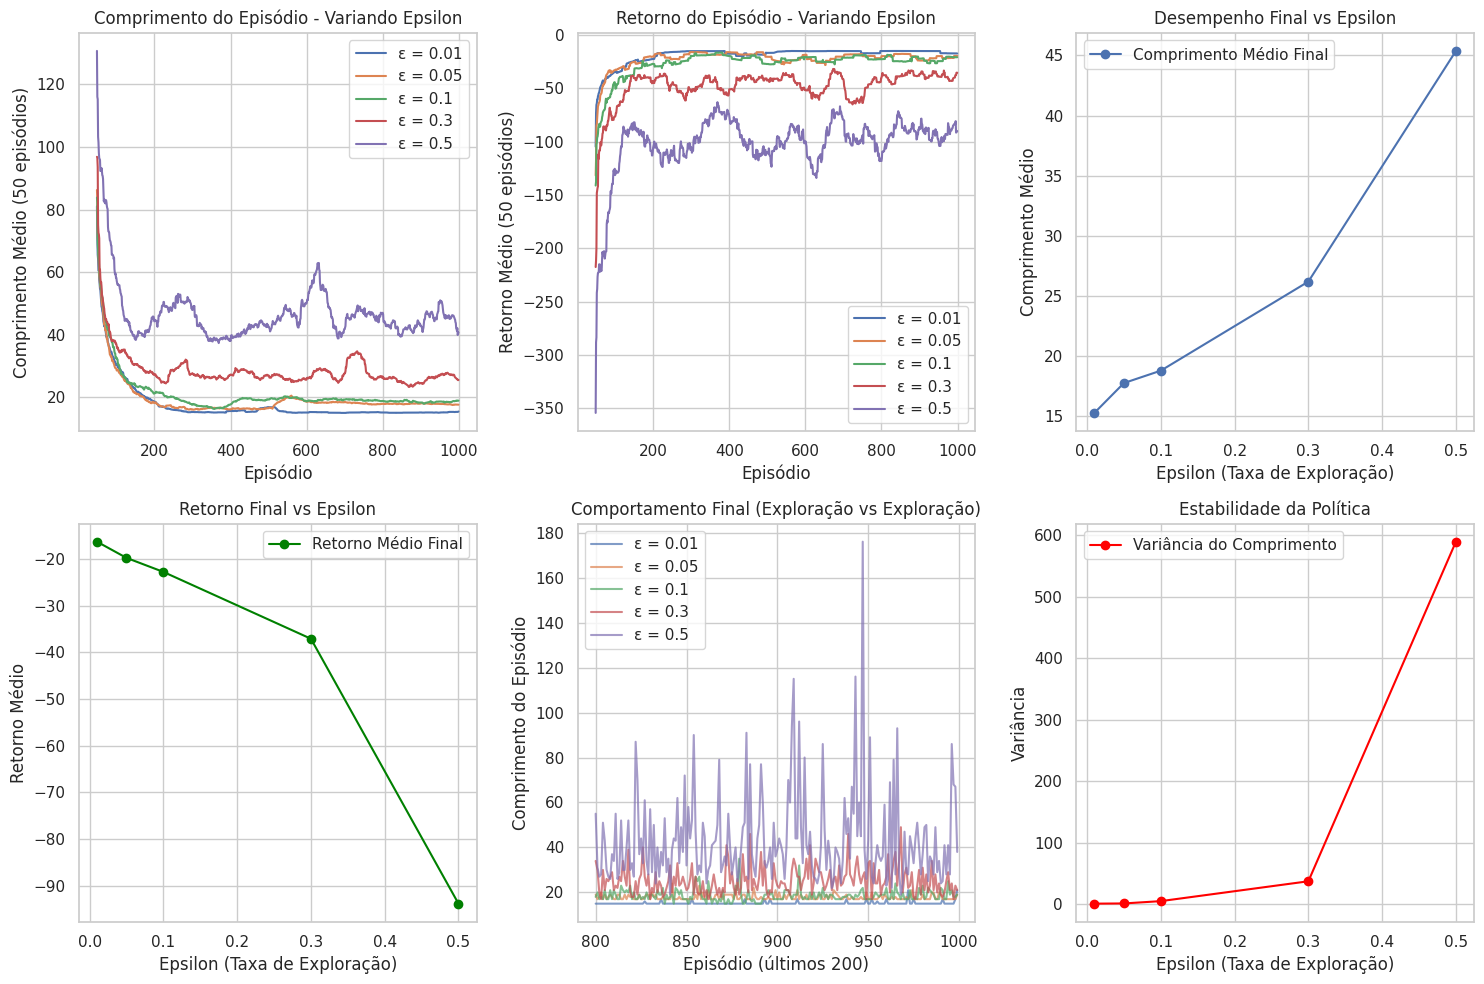


=== ANÁLISE DO IMPACTO DO EPSILON ===

Epsilon = 0.01:
  Comprimento médio final: 15.29
  Retorno médio final: -16.28
  Variância do comprimento: 0.97

Epsilon = 0.05:
  Comprimento médio final: 17.77
  Retorno médio final: -19.75
  Variância do comprimento: 1.30

Epsilon = 0.1:
  Comprimento médio final: 18.80
  Retorno médio final: -22.76
  Variância do comprimento: 5.06

Epsilon = 0.3:
  Comprimento médio final: 26.20
  Retorno médio final: -37.09
  Variância do comprimento: 37.32

Epsilon = 0.5:
  Comprimento médio final: 45.37
  Retorno médio final: -93.88
  Variância do comprimento: 589.07


In [48]:
# Plotar resultados para variação de epsilon
plt.figure(figsize=(15, 10))

# Plot 1: Comprimento ao longo dos episódios
plt.subplot(2, 3, 1)
for epsilon in epsilons_variar:
    ep_len = resultados_epsilon[epsilon]['ep_len']
    media_movel = pd.Series(ep_len).rolling(window=50).mean()
    plt.plot(media_movel, label=f'ε = {epsilon}')
plt.xlabel('Episódio')
plt.ylabel('Comprimento Médio (50 episódios)')
plt.title('Comprimento do Episódio - Variando Epsilon')
plt.legend()
plt.grid(True)

# Plot 2: Retorno ao longo dos episódios
plt.subplot(2, 3, 2)
for epsilon in epsilons_variar:
    ep_ret = resultados_epsilon[epsilon]['ep_ret']
    media_movel = pd.Series(ep_ret).rolling(window=50).mean()
    plt.plot(media_movel, label=f'ε = {epsilon}')
plt.xlabel('Episódio')
plt.ylabel('Retorno Médio (50 episódios)')
plt.title('Retorno do Episódio - Variando Epsilon')
plt.legend()
plt.grid(True)

# Plot 3: Desempenho final
plt.subplot(2, 3, 3)
comprimentos_finais_epsilon = []
retornos_finais_epsilon = []
for epsilon in epsilons_variar:
    ep_len = resultados_epsilon[epsilon]['ep_len']
    ep_ret = resultados_epsilon[epsilon]['ep_ret']
    comprimentos_finais_epsilon.append(np.mean(ep_len[-100:]))
    retornos_finais_epsilon.append(np.mean(ep_ret[-100:]))

plt.plot(epsilons_variar, comprimentos_finais_epsilon, 'o-', label='Comprimento Médio Final')
plt.xlabel('Epsilon (Taxa de Exploração)')
plt.ylabel('Comprimento Médio')
plt.title('Desempenho Final vs Epsilon')
plt.grid(True)
plt.legend()

# Plot 4: Retorno final
plt.subplot(2, 3, 4)
plt.plot(epsilons_variar, retornos_finais_epsilon, 'o-', color='green', label='Retorno Médio Final')
plt.xlabel('Epsilon (Taxa de Exploração)')
plt.ylabel('Retorno Médio')
plt.title('Retorno Final vs Epsilon')
plt.grid(True)
plt.legend()

# Plot 5: Trade-off exploração vs exploração (últimos 200 episódios)
plt.subplot(2, 3, 5)
for epsilon in epsilons_variar:
    ep_len = resultados_epsilon[epsilon]['ep_len'][-200:]
    plt.plot(range(800, 1000), ep_len, label=f'ε = {epsilon}', alpha=0.7)
plt.xlabel('Episódio (últimos 200)')
plt.ylabel('Comprimento do Episódio')
plt.title('Comportamento Final (Exploração vs Exploração)')
plt.legend()
plt.grid(True)

# Plot 6: Estabilidade da política
plt.subplot(2, 3, 6)
variancia_epsilon = []
for epsilon in epsilons_variar:
    ep_len = resultados_epsilon[epsilon]['ep_len']
    variancia_epsilon.append(np.var(ep_len[-100:]))

plt.plot(epsilons_variar, variancia_epsilon, 'o-', color='red', label='Variância do Comprimento')
plt.xlabel('Epsilon (Taxa de Exploração)')
plt.ylabel('Variância')
plt.title('Estabilidade da Política')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Análise textual
print("\n=== ANÁLISE DO IMPACTO DO EPSILON ===")
for i, epsilon in enumerate(epsilons_variar):
    print(f"\nEpsilon = {epsilon}:")
    print(f"  Comprimento médio final: {comprimentos_finais_epsilon[i]:.2f}")
    print(f"  Retorno médio final: {retornos_finais_epsilon[i]:.2f}")
    print(f"  Variância do comprimento: {variancia_epsilon[i]:.2f}")

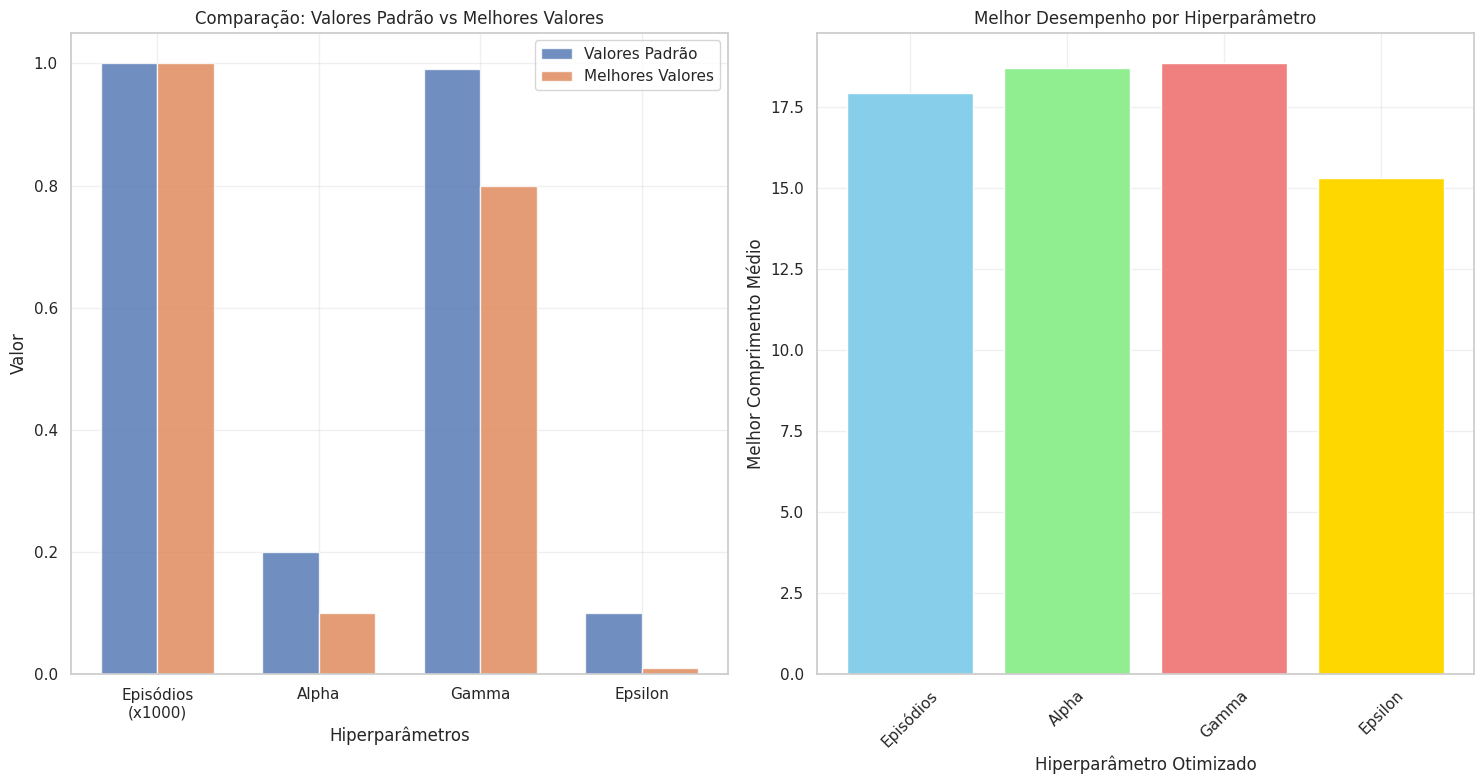


RESUMO FINAL - ANÁLISE DE HIPERPARÂMETROS DO SARSA

Valores padrão:
  EPISÓDIOS = 1000
  ALPHA = 0.2
  GAMMA = 0.99
  EPSILON = 0.1

Melhores valores encontrados:
  Melhor número de episódios: 1000 (comprimento: 17.92)
  Melhor alpha: 0.1 (comprimento: 18.69)
  Melhor gamma: 0.8 (comprimento: 18.83)
  Melhor epsilon: 0.01 (comprimento: 15.29)

Observações gerais:
  - O hiperparâmetro com maior impacto no desempenho foi: Epsilon
  - Menor comprimento médio alcançado: 15.29 passos
  - Diferença em relação aos valores padrão: 3.34 passos


In [49]:
# Comparação geral dos hiperparâmetros
plt.figure(figsize=(15, 8))

# Preparar dados para comparação
hiperparametros = ['Episódios', 'Alpha', 'Gamma', 'Epsilon']
valores_padrao = [1000, 0.2, 0.99, 0.1]

# Melhor desempenho para cada hiperparâmetro
melhor_episodios = episodios_variar[np.argmin(comprimentos_finais)]
melhor_alpha = alphas_variar[np.argmin(comprimentos_finais_alpha)]
melhor_gamma = gammas_variar[np.argmin(comprimentos_finais_gamma)]
melhor_epsilon = epsilons_variar[np.argmin(comprimentos_finais_epsilon)]

melhores_valores = [melhor_episodios, melhor_alpha, melhor_gamma, melhor_epsilon]

# Plot comparativo
plt.subplot(1, 2, 1)
categorias = ['Episódios\n(x1000)', 'Alpha', 'Gamma', 'Epsilon']
valores_norm_padrao = [1.0, 0.2, 0.99, 0.1]
valores_norm_melhor = [melhor_episodios/1000, melhor_alpha, melhor_gamma, melhor_epsilon]

x = np.arange(len(categorias))
width = 0.35

plt.bar(x - width/2, valores_norm_padrao, width, label='Valores Padrão', alpha=0.8)
plt.bar(x + width/2, valores_norm_melhor, width, label='Melhores Valores', alpha=0.8)

plt.xlabel('Hiperparâmetros')
plt.ylabel('Valor')
plt.title('Comparação: Valores Padrão vs Melhores Valores')
plt.xticks(x, categorias)
plt.legend()
plt.grid(True, alpha=0.3)

# Desempenho (comprimento médio) para cada melhor hiperparâmetro
plt.subplot(1, 2, 2)
desempenhos = [
    min(comprimentos_finais),
    min(comprimentos_finais_alpha),
    min(comprimentos_finais_gamma),
    min(comprimentos_finais_epsilon)
]

plt.bar(hiperparametros, desempenhos, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.xlabel('Hiperparâmetro Otimizado')
plt.ylabel('Melhor Comprimento Médio')
plt.title('Melhor Desempenho por Hiperparâmetro')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo final
print("\n" + "="*60)
print("RESUMO FINAL - ANÁLISE DE HIPERPARÂMETROS DO SARSA")
print("="*60)
print(f"\nValores padrão:")
print(f"  EPISÓDIOS = {EPISODIOS}")
print(f"  ALPHA = {ALPHA}")
print(f"  GAMMA = {GAMMA}")
print(f"  EPSILON = {EPSILON}")

print(f"\nMelhores valores encontrados:")
print(f"  Melhor número de episódios: {melhor_episodios} (comprimento: {min(comprimentos_finais):.2f})")
print(f"  Melhor alpha: {melhor_alpha} (comprimento: {min(comprimentos_finais_alpha):.2f})")
print(f"  Melhor gamma: {melhor_gamma} (comprimento: {min(comprimentos_finais_gamma):.2f})")
print(f"  Melhor epsilon: {melhor_epsilon} (comprimento: {min(comprimentos_finais_epsilon):.2f})")

print(f"\nObservações gerais:")
print(f"  - O hiperparâmetro com maior impacto no desempenho foi: {hiperparametros[np.argmin(desempenhos)]}")
print(f"  - Menor comprimento médio alcançado: {min(desempenhos):.2f} passos")
print(f"  - Diferença em relação aos valores padrão: {abs(min(desempenhos) - np.mean([comprimentos_finais[2], comprimentos_finais_alpha[1], comprimentos_finais_gamma[4], comprimentos_finais_epsilon[2]])):.2f} passos")